# Graph Convolutional Networks
## Máster Oficial: Big Data Science


https://www.unav.edu/web/instituto-de-ciencia-de-los-datos-e-inteligencia-artificial<br>

Autor: Darian Horacio Grass Boada


# Redes Neuronales de Grafos (GNNs), PyTorch Geometric

Las Redes Neuronales de Grafos (GNNs) son una de las arquitecturas más fascinantes y en rápida evolución en el campo del aprendizaje profundo. Diseñadas para procesar datos estructurados como grafos, las GNNs ofrecen una versatilidad y capacidad de aprendizaje notables.

Entre los diversos tipos de GNNs, las Redes Convolucionales de Grafos (GCNs) se han destacado como el modelo más prevalente y ampliamente aplicado. Las GCNs son innovadoras por su capacidad para aprovechar tanto las características de un nodo como su localidad para hacer predicciones, proporcionando una forma efectiva de manejar datos estructurados en grafos.

En este notebook, profundizaremos en la mecánica de la capa GCN y explicaremos su funcionamiento interno. Además, exploraremos su aplicación práctica para tareas de clasificación de nodos, utilizando PyTorch Geometric como nuestra herramienta de elección.

PyTorch Geometric es una extensión especializada de PyTorch creada específicamente para el desarrollo e implementación de GNNs. Es una biblioteca avanzada pero fácil de usar que proporciona un conjunto completo de herramientas para facilitar el aprendizaje basado en grafos. Para comenzar nuestro viaje, será necesaria la instalación de PyTorch Geometric. Si estás utilizando Google Colab, PyTorch ya debería estar instalado, por lo que solo necesitamos ejecutar algunos comandos adicionales.

In [1]:
# !pip -q install torch_geometric

import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Grafos y el Conjunto de Datos: Red del Club de Karate de Zachary

Los grafos son una estructura esencial para representar las relaciones entre objetos. Puedes encontrar datos de grafos en una multitud de escenarios del mundo real, como redes sociales y de computadoras, estructuras químicas de moléculas, procesamiento de lenguaje natural y reconocimiento de imágenes, por nombrar algunos.

En este notebook, estudiaremos el famoso y muy utilizado conjunto de datos del club de karate de Zachary. Este conjunto de datos encarna las relaciones formadas dentro de un club de karate, tal como lo observó Wayne W. Zachary durante la década de 1970. Es una especie de red social, donde cada nodo representa a un miembro del club y las aristas entre nodos representan interacciones que ocurrieron fuera del entorno del club.

En este escenario particular, los miembros del club se dividen en cuatro grupos distintos. Nuestra tarea es asignar el grupo correcto a cada miembro (clasificación de nodos), basándonos en el patrón de sus interacciones.

Importemos la red con la función incorporada de PyG y tratemos de entender el objeto Datasets que utiliza.

In [6]:
from torch_geometric.datasets import KarateClub

# Import dataset from PyTorch Geometric
dataset = KarateClub()

# Print information
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

c:\Users\darian\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\datasets\qm9.py:22: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf . Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem . (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:84.)
  conversion = torch.tensor([


KarateClub()
------------
Number of graphs: 1
Number of features: 34
Number of classes: 4


# Inspección de la red

Esat red representada con 1 grafo, donde cada nodo tiene un vector de características de 34 dimensiones y es parte de una de las cuatro clases (nuestros cuatro grupos). En realidad, el objeto Datasets puede verse como una colección de objetos Data (grafos).

Podemos inspeccionar más a fondo nuestro grafo único para conocer más sobre él.

In [7]:
# Print first element
print(f'Graph: {dataset[0]}')

Graph: Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


# El Objeto Data y sus Componentes

El objeto Data es particularmente interesante. Imprimirlo ofrece un buen resumen del grafo que estamos estudiando:

- `x=[34, 34]` es la matriz de características de los nodos con forma (número de nodos, número de características). En nuestro caso, significa que tenemos 34 nodos (nuestros 34 miembros), cada nodo está asociado a un vector de características de 34 dimensiones.
- `edge_index=[2, 156]` representa la conectividad del grafo (cómo están conectados los nodos) con forma (2, número de aristas dirigidas).
- `y=[34]` son las etiquetas de verdad fundamental de los nodos. En este problema, cada nodo se asigna a una clase (grupo), por lo que tenemos un valor para cada nodo.
- `train_mask=[34]` es un atributo opcional que indica qué nodos deben usarse para el entrenamiento con una lista de declaraciones Verdadero o Falso.

Imprimamos cada uno de estos tensores para entender qué almacenan. Comencemos con las características de los nodos.

In [8]:
data = dataset[0]

print(f'x = {data.x.shape}')
print(data.x)

x = torch.Size([34, 34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


# Matriz de Características de los Nodos y Índice de Aristas

Aquí, la matriz de características de los nodos `x` es una matriz identidad: no contiene ninguna información relevante sobre los nodos. Podría contener información como la edad, el nivel de habilidad, etc., pero este no es el caso en este conjunto de datos. Esto significa que tendremos que clasificar nuestros nodos solo mirando sus conexiones.

Ahora, imprimamos el índice de aristas.

In [9]:
print(f'edge_index = {data.edge_index.shape}')
print(data.edge_index)

edge_index = torch.Size([2, 156])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3, 

# Conectividad de los Nodos y Formato COO

En la teoría de grafos y el análisis de redes, la conectividad entre los nodos se almacena utilizando una variedad de estructuras de datos. `edge_index` es una de estas estructuras de datos, donde las conexiones del grafo se almacenan en dos listas (156 aristas dirigidas, que equivalen a 78 aristas bidireccionales). La razón de estas dos listas es que una lista almacena los nodos fuente, mientras que la segunda identifica los nodos destino.

Este método se conoce como formato de lista de coordenadas (COO), que es esencialmente un medio para almacenar eficientemente una matriz dispersa. Las matrices dispersas son estructuras de datos que almacenan eficientemente matrices con una mayoría de elementos cero. En el formato COO, solo se almacenan los elementos no cero, ahorrando memoria y recursos computacionales.

Contrariamente, una forma más intuitiva y directa de representar la conectividad del grafo es a través de una matriz de adyacencia. Esta es una matriz cuadrada donde cada elemento especifica la presencia o ausencia de una arista de nodo a nodo en el grafo. En otras palabras, un elemento no cero implica una conexión de nodo a nodo, y un cero indica que no hay conexión directa.

# Matriz de Adyacencia

Una matriz de adyacencia, sin embargo, no es tan eficiente en términos de espacio como el formato COO para matrices dispersas o grafos con menos aristas. Sin embargo, para la claridad y fácil interpretación, la matriz de adyacencia sigue siendo una opción popular para representar la conectividad del grafo.

La matriz de adyacencia puede inferirse del `edge_index` con una función de utilidad `to_dense_adj()`.

In [14]:
from torch_geometric.utils import to_dense_adj

A = to_dense_adj(data.edge_index)[0].numpy().astype(int)
print(f'A = {A.shape}')
print(A)

RuntimeError: Numpy is not available

# Matriz de Adyacencia Dispersa y Etiquetas ground truth

Con los datos de grafos, es relativamente poco común que los nodos estén densamente interconectados. Como puedes ver, nuestra matriz de adyacencia es dispersa (llena de ceros).

En muchos grafos del mundo real, la mayoría de los nodos están conectados solo a unos pocos otros nodos, lo que resulta en un gran número de ceros en la matriz de adyacencia. Almacenar tantos ceros no es eficiente en absoluto, por lo que PyG adopta el formato COO.

Por el contrario, las etiquetas ground truth son fáciles de entender.

In [ ]:
print(f'y = {data.y.shape}')
print(data.y)

y = torch.Size([34])
tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


# Etiquetas ground-truth y Máscara de Entrenamiento

Nuestras etiquetas ground-truth de los nodos almacenadas en `y` simplemente codifican el número de grupo (0, 1, 2, 3) para cada nodo, por eso tenemos 34 valores.

Finalmente, imprimamos la máscara de entrenamiento.

In [ ]:
print(f'train_mask = {data.train_mask.shape}')
print(data.train_mask)

train_mask = torch.Size([34])
tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])


# Máscara de Entrenamiento y Propiedades del Grafo

La máscara de entrenamiento muestra qué nodos se supone que deben usarse para el entrenamiento con declaraciones Verdaderas. Estos nodos representan el conjunto de entrenamiento, mientras que los demás pueden considerarse como el conjunto de prueba. Esta división ayuda en la evaluación del modelo al proporcionar datos no vistos para las pruebas.

¡Pero aún no hemos terminado! El objeto Data tiene mucho más que ofrecer. Proporciona varias funciones de utilidad que permiten la investigación de varias propiedades del grafo. Por ejemplo:

- `is_directed()` te dice si el grafo es dirigido. Un grafo dirigido significa que la matriz de adyacencia no es simétrica, es decir, la dirección de las aristas importa en las conexiones entre los nodos.
- `isolated_nodes()` verifica si algunos nodos no están conectados al resto del grafo. Estos nodos probablemente presentarán desafíos en tareas como la clasificación debido a su falta de conexiones.
- `has_self_loops()` indica si al menos un nodo está conectado a sí mismo. Esto es distinto del concepto de bucles: un bucle implica un camino que comienza y termina en el mismo nodo, atravesando otros nodos en el medio.

En el contexto del conjunto de datos del club de karate de Zachary, todas estas propiedades devuelven Falso. Esto implica que el grafo no es dirigido, no tiene ningún nodo aislado y ninguno de sus nodos está conectado a sí mismo.

In [ ]:
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


# Conversión a NetworkX y Visualización del Grafo

Finalmente, podemos convertir un grafo de PyTorch Geometric a la popular biblioteca de grafos NetworkX usando `to_networkx`. Esto es particularmente útil para visualizar un grafo pequeño con networkx y matplotlib.

Vamos a trazar nuestro conjunto de datos con un color diferente para cada grupo.

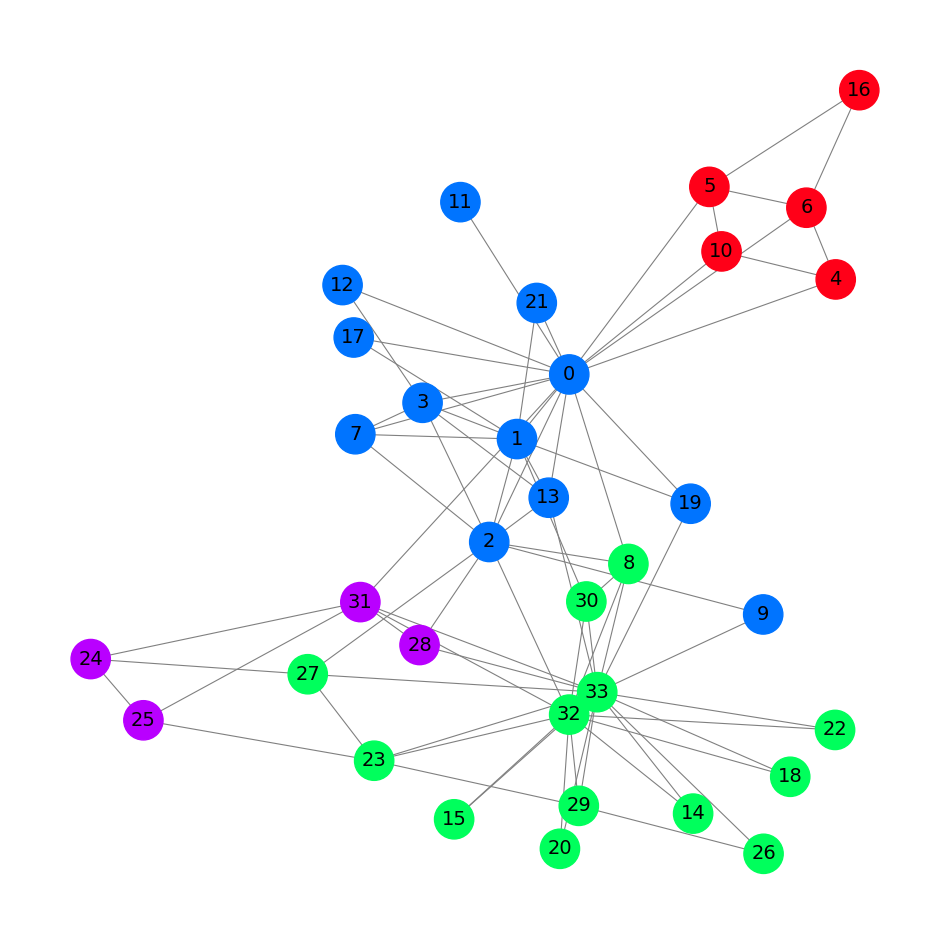

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()

# Implementación de una GCN

PyTorch Geometric proporciona la función `GCNConv`, que implementa directamente la capa convolucional de grafo.

En este ejemplo, crearemos una Red Convolutiva de Grafo básica con una única capa GCN, una función de activación ReLU y una capa de salida lineal. Esta capa de salida producirá cuatro valores correspondientes a nuestras cuatro categorías, siendo el valor más alto el que determina la clase de cada nodo.

En el siguiente bloque de código, definimos la capa GCN con una capa oculta tridimensional.

In [ ]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 3)
        self.out = Linear(3, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z

model = GCN()
print(model)

GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)


# Agregación de Capas y Bucle de Entrenamiento

Si agregáramos una segunda capa GCN, nuestro modelo no solo agregaría vectores de características de los vecinos de cada nodo, sino también de los vecinos de estos vecinos.

Podemos apilar varias capas de grafo para agregar valores cada vez más distantes, pero hay una trampa: si agregamos demasiadas capas, la agregación se vuelve tan intensa que todos los embeddings terminan pareciéndose. Este fenómeno se llama suavizado excesivo y puede ser un problema real cuando tienes demasiadas capas.

Ahora que hemos definido nuestra GNN, escribamos un bucle de entrenamiento simple con PyTorch. Elegí una pérdida de entropía cruzada regular ya que es una tarea de clasificación multiclase, con Adam como optimizador. En este artículo, no implementaremos una división de entrenamiento/prueba para mantener las cosas simples y centrarnos en cómo aprenden las GNNs.

El bucle de entrenamiento es estándar: intentamos predecir las etiquetas correctas, y comparamos los resultados de la GCN con los valores almacenados en `data.y`. El error es calculado por la pérdida de entropía cruzada y retropropagado con Adam para afinar los pesos y sesgos de nuestra GNN. Finalmente, imprimimos métricas cada 10 épocas.

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# Data for animations
embeddings = []
losses = []
accuracies = []
outputs = []

# Training loop
for epoch in range(201):
    # Clear gradients
    optimizer.zero_grad()

    # Forward pass
    h, z = model(data.x, data.edge_index)

    # Calculate loss function
    loss = criterion(z, data.y)

    # Calculate accuracy
    acc = accuracy(z.argmax(dim=1), data.y)

    # Compute gradients
    loss.backward()

    # Tune parameters
    optimizer.step()

    # Store data for animations
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))

    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

Epoch   0 | Loss: 1.38 | Acc: 38.24%
Epoch  10 | Loss: 1.23 | Acc: 38.24%
Epoch  20 | Loss: 1.02 | Acc: 52.94%
Epoch  30 | Loss: 0.75 | Acc: 85.29%
Epoch  40 | Loss: 0.50 | Acc: 88.24%
Epoch  50 | Loss: 0.31 | Acc: 97.06%
Epoch  60 | Loss: 0.19 | Acc: 100.00%
Epoch  70 | Loss: 0.11 | Acc: 100.00%
Epoch  80 | Loss: 0.07 | Acc: 100.00%
Epoch  90 | Loss: 0.05 | Acc: 100.00%
Epoch 100 | Loss: 0.03 | Acc: 100.00%
Epoch 110 | Loss: 0.03 | Acc: 100.00%
Epoch 120 | Loss: 0.02 | Acc: 100.00%
Epoch 130 | Loss: 0.02 | Acc: 100.00%
Epoch 140 | Loss: 0.01 | Acc: 100.00%
Epoch 150 | Loss: 0.01 | Acc: 100.00%
Epoch 160 | Loss: 0.01 | Acc: 100.00%
Epoch 170 | Loss: 0.01 | Acc: 100.00%
Epoch 180 | Loss: 0.01 | Acc: 100.00%
Epoch 190 | Loss: 0.01 | Acc: 100.00%
Epoch 200 | Loss: 0.01 | Acc: 100.00%


# Resultados y Visualización

¡Genial! Sin mucha sorpresa, alcanzamos el 100% de precisión en el conjunto de entrenamiento (conjunto de datos completo). Esto significa que nuestro modelo aprendió a asignar correctamente a cada miembro del club de karate a su grupo correcto.

Podemos producir una visualización ordenada animando el grafo y ver la evolución de las predicciones de la GNN durante el proceso de entrenamiento.

In [ ]:
%%capture
from IPython.display import HTML
from matplotlib import animation
plt.rcParams["animation.bitrate"] = 3000

def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=800,
                    node_color=outputs[i],
                    cmap="hsv",
                    vmin=-2,
                    vmax=3,
                    width=0.8,
                    edge_color="grey",
                    font_size=14
                    )
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=20)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')

anim = animation.FuncAnimation(fig, animate, \
            np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())

In [ ]:
display(html)

# Predicciones y Aprendizaje de la GCN

Las primeras predicciones son aleatorias, pero la GCN etiqueta perfectamente cada nodo después de un tiempo. De hecho, el grafo final es el mismo que el que trazamos al final de la primera sección. Pero, ¿qué aprende realmente la GCN?

Al agregar características de los nodos vecinos, la GNN aprende una representación vectorial (o embedding) de cada nodo en la red. En nuestro modelo, la capa final solo aprende cómo usar estas representaciones para producir las mejores clasificaciones. Sin embargo, los embeddings son los verdaderos productos de las GNNs.

Imprimamos los embeddings aprendidos por nuestro modelo.

In [ ]:
# Print embeddings
print(f'Final embeddings = {h.shape}')
print(h)

Final embeddings = torch.Size([34, 3])
tensor([[1.6612e+00, 0.0000e+00, 2.3195e+00],
        [7.4781e-01, 0.0000e+00, 2.9063e+00],
        [1.1971e+00, 4.3632e-01, 2.4397e+00],
        [1.3211e+00, 0.0000e+00, 2.6647e+00],
        [2.6203e+00, 0.0000e+00, 3.4205e-01],
        [2.8520e+00, 0.0000e+00, 2.4036e-01],
        [2.7121e+00, 0.0000e+00, 2.3544e-01],
        [1.3377e+00, 0.0000e+00, 2.1697e+00],
        [1.4876e-01, 1.9301e+00, 1.7901e+00],
        [1.3196e+00, 4.2404e-01, 2.0358e+00],
        [2.6144e+00, 0.0000e+00, 2.3528e-01],
        [1.0266e+00, 5.2631e-02, 1.9873e+00],
        [1.2915e+00, 7.1028e-02, 2.2134e+00],
        [1.2363e+00, 1.6638e-01, 2.2209e+00],
        [2.2367e-01, 2.3517e+00, 1.9111e+00],
        [1.3214e-01, 2.3632e+00, 1.8512e+00],
        [2.5772e+00, 0.0000e+00, 1.6182e-01],
        [1.1631e+00, 6.4542e-02, 2.0901e+00],
        [7.9371e-02, 2.2068e+00, 1.8220e+00],
        [1.1802e+00, 3.0250e-01, 2.0183e+00],
        [3.5763e-06, 2.2491e+00, 1.7950e+

# Dimensiones de los Embeddings

Como puedes ver, los embeddings no necesitan tener las mismas dimensiones que los vectores de características. Aquí, elegí reducir el número de dimensiones de 34 (`dataset.num_features`) a tres para obtener una buena visualización en 3D.

Vamos a trazar estos embeddings antes de que ocurra cualquier entrenamiento, en la época 0.

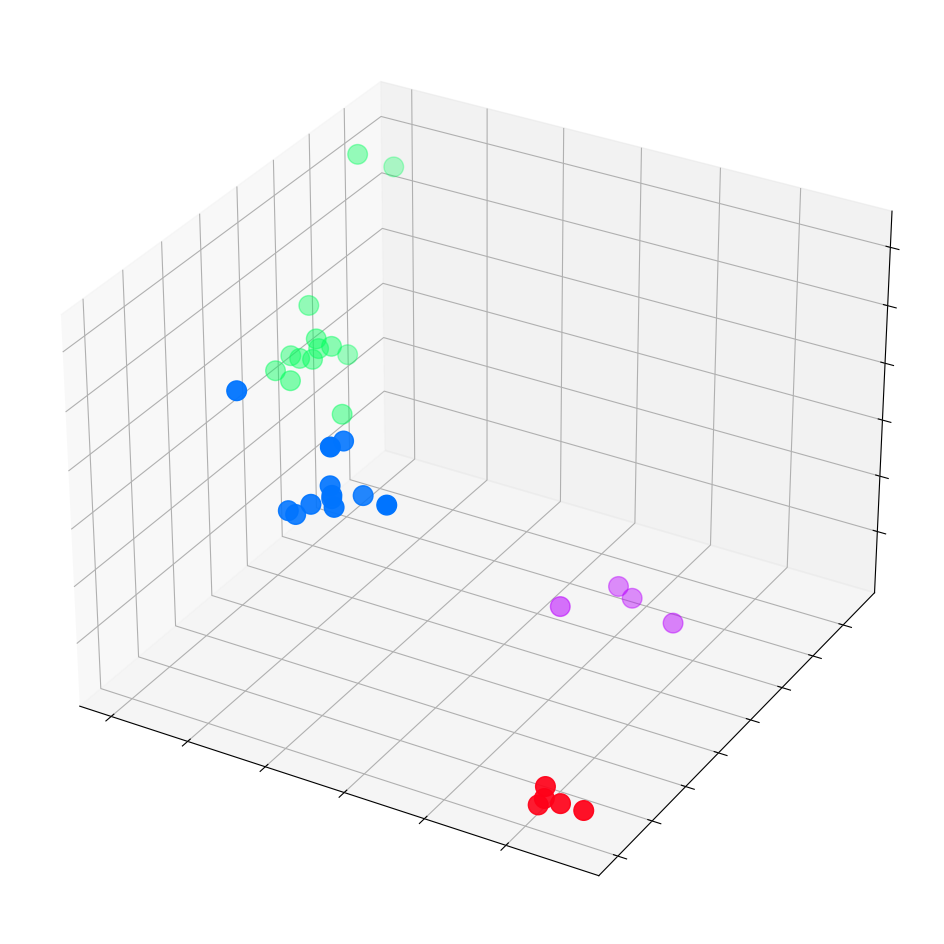

In [ ]:
# Get first embedding at epoch = 0
embed = h.detach().cpu().numpy()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)

plt.show()

# Evolución de los Embeddings

Vemos cada nodo del club de karate de Zachary con sus etiquetas verdaderas (y no las predicciones del modelo). Por ahora, están dispersos ya que la GNN aún no está entrenada. Pero si trazamos estos embeddings en cada paso del bucle de entrenamiento, podríamos visualizar lo que la GNN realmente aprende.

Veamos cómo evolucionan con el tiempo, a medida que la GCN se vuelve cada vez mejor clasificando nodos.

In [ ]:
%%capture

def animate(i):
    embed = embeddings[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=40)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')
ax = fig.add_subplot(projection='3d')
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

anim = animation.FuncAnimation(fig, animate, \
              np.arange(0, 200, 10), interval=800, repeat=True)
html = HTML(anim.to_html5_video())

In [ ]:
display(html)

# Aprendizaje de Embeddings y Dimensionalidad

Nuestra Red Convolutiva de Grafo (GCN) ha aprendido efectivamente embeddings que agrupan nodos similares en clusters distintos. Esto permite que la capa lineal final los distinga en clases separadas con facilidad.

Los embeddings no son exclusivos de las GNNs: se pueden encontrar en todas partes en el aprendizaje profundo. Tampoco tienen que ser 3D: en realidad, rara vez lo son. Por ejemplo, los modelos de lenguaje como BERT producen embeddings con 768 o incluso 1024 dimensiones.

Las dimensiones adicionales almacenan más información sobre nodos, texto, imágenes, etc., pero también crean modelos más grandes que son más difíciles de entrenar. Por eso es ventajoso mantener embeddings de baja dimensión el mayor tiempo posible.

# Conclusión

Las Redes Convolutivas de Grafo son una arquitectura increíblemente versátil que se puede aplicar en muchos contextos. En este artículo, nos familiarizamos con la biblioteca PyTorch Geometric y objetos como Datasets y Data. Luego, reconstruimos con éxito una capa convolutiva de grafo desde cero. A continuación, pusimos la teoría en práctica implementando una GCN, lo que nos dio una comprensión de los aspectos prácticos y cómo interactúan los componentes individuales. Finalmente, visualizamos el proceso de entrenamiento y obtuvimos una perspectiva clara de lo que implica para una red de este tipo.

El club de karate de Zachary es un conjunto de datos simplista, pero es suficiente para entender los conceptos más importantes en datos de grafo y GNNs. Aunque solo hablamos de la clasificación de nodos en este artículo, hay otras tareas que las GNNs pueden lograr: predicción de enlaces (por ejemplo, para recomendar un amigo), clasificación de grafos (por ejemplo, para etiquetar moléculas), generación de grafos (por ejemplo, para crear nuevas moléculas), y así sucesivamente.

Más allá de la GCN, numerosas capas y arquitecturas de GNN han sido propuestas por los investigadores. En el próximo artículo, presentaremos la arquitectura de la Red de Atención de Grafo (GAT), que calcula dinámicamente el factor de normalización de la GCN y la importancia de cada conexión con un mecanismo de atención.